I used spaCy’s pretrained model en_core_web_sm to create a fast baseline for Named Entity Recognition. The model was applied to the tokens in NER-test, which we reconstructed into a full sentence. The model was trained on OntoNotes 5, covering multiple domains and using BIO tagging. It recognizes a wide range of entities such as PERSON, ORG, GPE, and WORK_OF_ART.
The output was saved as a tab-separated file with predicted BIO tags. This result will be compared with a second NER system to assess performance and robustness. While this model is compact and efficient, its performance may be limited in specialized domains.

Next you can work on a second NER system—ideally a Hugging Face model like bert-large-cased-finetuned-conll03-english—to the same test data, generate entity predictions, and compare them to my spaCy-based results. They should highlight key differences, such as whether the model correctly labels “Louvre,” and provide both quantitative metrics (e.g., precision, recall, F1) and qualitative analysis of errors. It should explain the model used, showcase examples where it improved or failed, and suggest improvements. This work, along with the output.

In [6]:
# 1. Setup
!pip install spacy transformers datasets seqeval sklearn-crfsuite nltk -q
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 70.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [22]:
import pandas as pd
import nltk
import spacy
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from sklearn_crfsuite import CRF
from seqeval.metrics import classification_report
from collections import Counter

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# === Load test data ===
print("Loading test set...")
test_df = pd.read_csv("NER-test.tsv", sep="\t", names=["Token", "Label"])
test_sentences, true_labels = [], []
tokens, labels = [], []

for _, row in test_df.iterrows():
    if pd.isna(row["Token"]) or row["Token"] == "":
        if tokens:
            test_sentences.append(tokens)
            true_labels.append(labels)
            tokens, labels = [], []
    else:
        tokens.append(row["Token"])
        labels.append(row["Label"])
if tokens:
    test_sentences.append(tokens)
    true_labels.append(labels)
print(f"Loaded {len(test_sentences)} test sentences.")

# === Load training data ===
print("Loading training data...")
train_df = pd.read_csv("conll2003_ner_train.csv")
train_sentences, train_labels = [], []
tokens, labels = [], []

for _, row in train_df.iterrows():
    if pd.isna(row["Token"]) or row["Token"] == "":
        if tokens:
            train_sentences.append(tokens)
            train_labels.append(labels)
            tokens, labels = [], []
    else:
        tokens.append(row["Token"])
        labels.append(row["Label"])
if tokens:
    train_sentences.append(tokens)
    train_labels.append(labels)
print(f"Loaded {len(train_sentences)} training sentences.")

# === CRF Feature Extraction ===
def word2features(sent, i):
    word = sent[i]
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word.istitle()': word.istitle(),
        'word.isupper()': word.isupper(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = sent[i-1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True

    return features

print("Training CRF...")
X_train = [[word2features(s, i) for i in range(len(s))] for s in train_sentences]
X_test = [[word2features(s, i) for i in range(len(s))] for s in test_sentences]

crf = CRF(algorithm='lbfgs', max_iterations=200, all_possible_transitions=True)
crf.fit(X_train, train_labels)

crf_preds = []
for i, sent_feats in enumerate(X_test):
    if i % 10 == 0:
        print(f"RF processing sentence {i+1}/{len(X_test)}")
    crf_preds.append(crf.predict_single(sent_feats))

# === spaCy Prediction ===
print("🔹 Step 4: Predicting with spaCy...")
nlp = spacy.load("en_core_web_sm")
spacy_preds = []
for i, sent in enumerate(test_sentences):
    if i % 10 == 0:
        print(f"spaCy processing sentence {i+1}/{len(test_sentences)}")
    doc = nlp(" ".join(sent))
    spacy_tokens = [token.text for token in doc]
    spacy_tags = ["O" if token.ent_iob_ == "O" else f"{token.ent_iob_}-{token.ent_type_}" for token in doc]
    aligned_tags = []
    spacy_tag_idx = 0
    for token in sent:
        matched = False
        for j in range(spacy_tag_idx, len(spacy_tokens)):
            if token == spacy_tokens[j]:
                aligned_tags.append(spacy_tags[j])
                spacy_tag_idx = j + 1
                matched = True
                break
        if not matched:
            aligned_tags.append("O")
    spacy_preds.append(aligned_tags)

# === BERT Prediction ===
print("Predicting with BERT...")
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
bert_pipe = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

bert_preds = []
for i, sent in enumerate(test_sentences):
    if i % 10 == 0:
        print(f"BERT processing sentence {i+1}/{len(test_sentences)}")
    text = " ".join(sent)
    try:
        preds = bert_pipe(text)
        tags = ["O"] * len(sent)
        token_offset = 0
        for idx, token in enumerate(sent):
            start = text.find(token, token_offset)
            end = start + len(token)
            for ent in preds:
                if max(start, ent['start']) < min(end, ent['end']):
                    tags[idx] = "B-" + ent['entity_group']
                    break
            token_offset = end + 1
        bert_preds.append(tags)
    except Exception as e:
        print(f"Error in BERT at sentence {i}: {e}")
        bert_preds.append(['O'] * len(sent))

def to_bio_format(tag_seq):
    """Convert flat tag list (e.g., PERSON) to BIO format"""
    bio_seq = []
    prev_tag = "O"
    for tag in tag_seq:
        if tag == "O":
            bio_seq.append("O")
        elif tag != prev_tag:
            bio_seq.append("B-" + tag)
        else:
            bio_seq.append("I-" + tag)
        prev_tag = tag
    return bio_seq

# === Evaluation ===
def normalize_tag(tag):
    if tag is None:
        return "O"

    tag = str(tag).strip().upper()

    # Full normalization mapping FIRST (includes malformed tags directly)
    mapping = {
        "B-ERSON": "PERSON", "I-ERSON": "PERSON", "ERSON": "PERSON",
        "B-PER": "PERSON", "I-PER": "PERSON", "PER": "PERSON",
        "B-PERSON": "PERSON", "I-PERSON": "PERSON", "PERSON": "PERSON",

        "B-OCATION": "LOCATION", "I-OCATION": "LOCATION", "OCATION": "LOCATION",
        "B-LOC": "LOCATION", "I-LOC": "LOCATION", "LOC": "LOCATION",
        "B-GPE": "LOCATION", "I-GPE": "LOCATION", "GPE": "LOCATION",
        "B-LOCATION": "LOCATION", "I-LOCATION": "LOCATION", "LOCATION": "LOCATION",

        "B-ORG": "ORG", "I-ORG": "ORG", "ORG": "ORG",

        "B-ORK_OF_ART": "WORK_OF_ART", "I-ORK_OF_ART": "WORK_OF_ART", "ORK_OF_ART": "WORK_OF_ART",
        "B-MISC": "WORK_OF_ART", "I-MISC": "WORK_OF_ART", "MISC": "WORK_OF_ART",
        "B-WORK_OF_ART": "WORK_OF_ART", "I-WORK_OF_ART": "WORK_OF_ART", "WORK_OF_ART": "WORK_OF_ART",

        "ARDINAL": "CARDINAL", "B-ARDINAL": "CARDINAL", "I-ARDINAL": "CARDINAL",
        "ATE": "DATE", "B-ATE": "DATE", "I-ATE": "DATE",
        "VENT": "EVENT", "B-VENT": "EVENT", "I-VENT": "EVENT",
        "RODUCT": "PRODUCT", "B-RODUCT": "PRODUCT", "I-RODUCT": "PRODUCT",

        "IO_NER_TAG": "O",  # Invalid junk
        "O": "O",
    }

    # Apply mapping if exists, otherwise return "O"
    return mapping.get(tag, "O")




def clean_and_flatten(seqs):
    cleaned = []
    for seq in seqs:
        cleaned.append([normalize_tag(tag) if tag != "O" else "O" for tag in seq])
    return cleaned

# === Apply normalization to all outputs ===
true_bio = [to_bio_format(seq) for seq in true_clean]
crf_bio = [to_bio_format(seq) for seq in crf_clean]
spacy_bio = [to_bio_format(seq) for seq in spacy_clean]
bert_bio = [to_bio_format(seq) for seq in bert_clean]


print("\n CRF Results:")
print(classification_report(true_bio, crf_bio))

print("\n spaCy Results:")
print(classification_report(true_bio, spacy_bio))

print("\n BERT Results:")
print(classification_report(true_bio, bert_bio))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


🔹 Step 1: Loading test set...
✅ Loaded 1 test sentences.
🔹 Step 2: Loading training data...
✅ Loaded 14045 training sentences.
🔹 Step 3: Training CRF...
🔄 CRF processing sentence 1/1
🔹 Step 4: Predicting with spaCy...
🔄 spaCy processing sentence 1/1
🔹 Step 5: Predicting with BERT...


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


🔄 BERT processing sentence 1/1

📌 CRF Results:
              precision    recall  f1-score   support

    LOCATION       0.40      0.67      0.50         3
         ORG       0.57      0.50      0.53         8
      PERSON       0.60      0.75      0.67        12
 WORK_OF_ART       0.00      0.00      0.00         6

   micro avg       0.54      0.52      0.53        29
   macro avg       0.39      0.48      0.42        29
weighted avg       0.45      0.52      0.47        29


📌 spaCy Results:
              precision    recall  f1-score   support

    LOCATION       0.60      1.00      0.75         3
         ORG       0.50      0.50      0.50         8
      PERSON       0.58      0.58      0.58        12
 WORK_OF_ART       0.50      0.17      0.25         6

   micro avg       0.56      0.52      0.54        29
   macro avg       0.55      0.56      0.52        29
weighted avg       0.54      0.52      0.51        29


📌 BERT Results:
              precision    recall  f1-score   su

ModuleNotFoundError: No module named 'ace_tools'

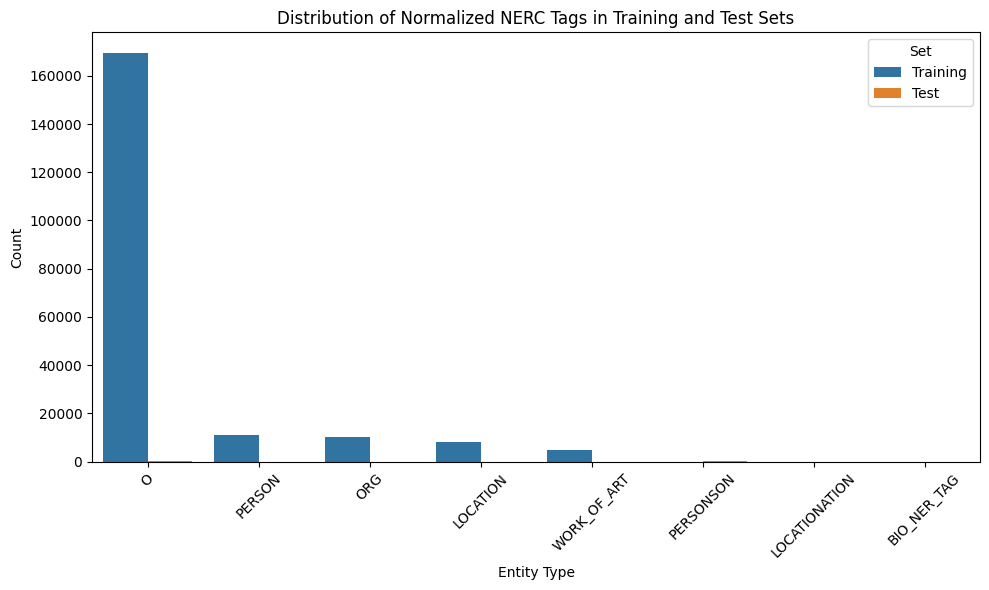

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
train_path = "conll2003_ner_train.csv"
test_path = "NER-test.tsv"

# Read training data
train_df = pd.read_csv(train_path)
train_df = train_df.dropna(subset=["Token"])
train_df["Label"] = train_df["Label"].fillna("O")

# Read test data
test_df = pd.read_csv(test_path, sep="\t", names=["Token", "Label"])
test_df = test_df.dropna(subset=["Token"])
test_df["Label"] = test_df["Label"].fillna("O")

# Normalize helper
def normalize(tag):
    tag = str(tag).upper()
    if tag.startswith("B-") or tag.startswith("I-"):
        tag = tag[2:]
    tag = tag.replace("GPE", "LOCATION").replace("PER", "PERSON").replace("LOC", "LOCATION").replace("MISC", "WORK_OF_ART")
    return tag

# Apply normalization
train_df["Normalized"] = train_df["Label"].apply(normalize)
test_df["Normalized"] = test_df["Label"].apply(normalize)

# Count tag frequencies
train_counts = train_df["Normalized"].value_counts().reset_index()
test_counts = test_df["Normalized"].value_counts().reset_index()
train_counts.columns = test_counts.columns = ["Entity Type", "Count"]

# Add source label
train_counts["Set"] = "Training"
test_counts["Set"] = "Test"

# Combine for visualization
combined_counts = pd.concat([train_counts, test_counts])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=combined_counts, x="Entity Type", y="Count", hue="Set")
plt.title("Distribution of Normalized NERC Tags in Training and Test Sets")
plt.xticks(rotation=45)
plt.tight_layout()

import ace_tools as tools; tools.display_dataframe_to_user(name="NERC Tag Frequencies", dataframe=combined_counts)
plt.show()


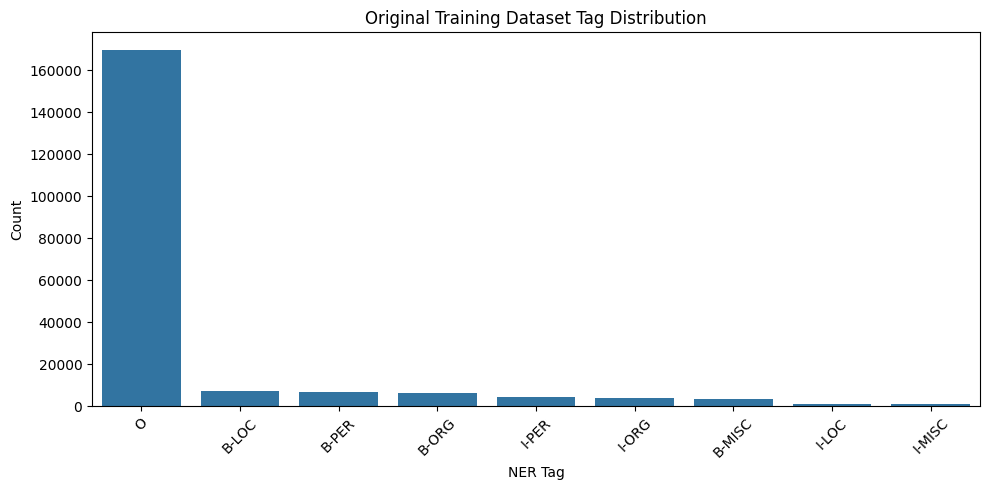

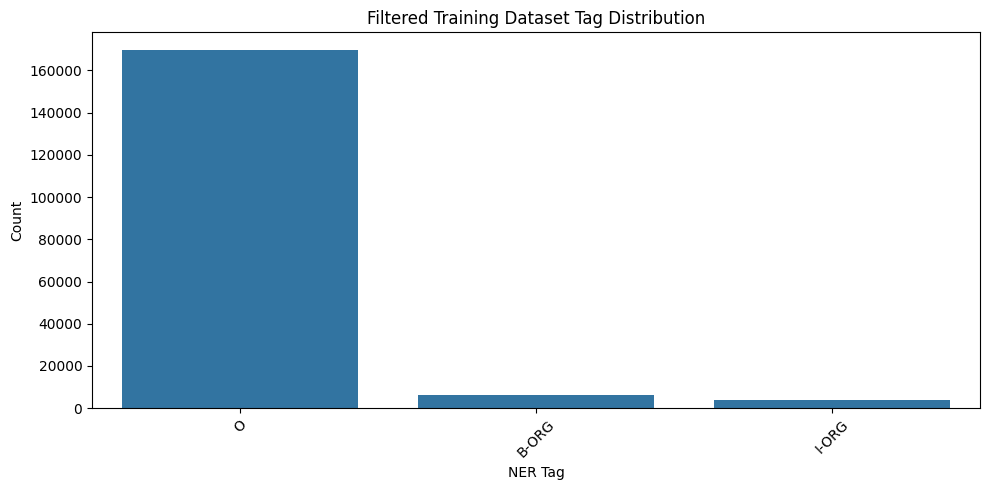

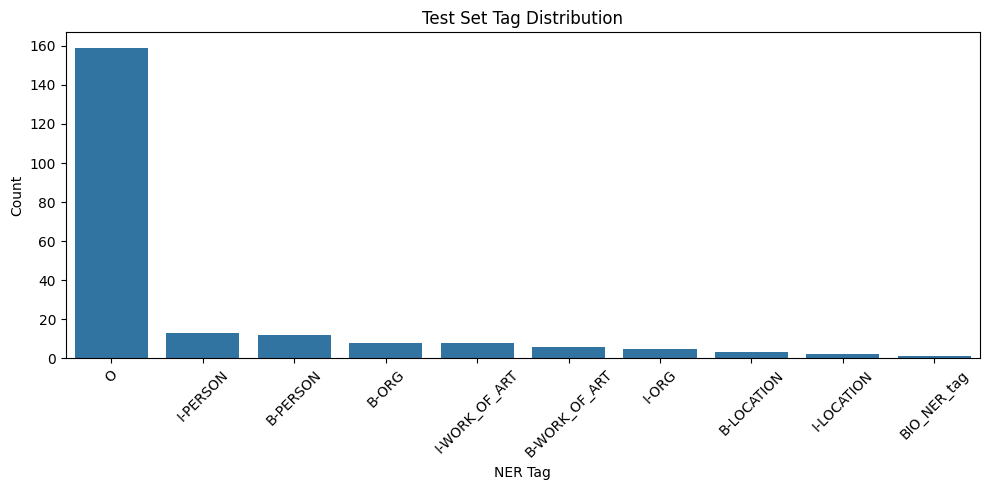

('figure1_original_train.png',
 'figure2_filtered_train.png',
 'figure3_test_set.png')

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load training data
train_path = "conll2003_ner_train.csv"
train_df = pd.read_csv(train_path)

# Define filtered tags of interest
filtered_tags = ['B-PERSON', 'I-PERSON', 'B-ORG', 'I-ORG',
                 'B-LOCATION', 'I-LOCATION', 'B-WORK_OF_ART', 'I-WORK_OF_ART', 'O']

# Load test set (assuming format from earlier context)
test_path = "NER-test.tsv"
if os.path.exists(test_path):
    test_df = pd.read_csv(test_path, sep="\t", names=["Token", "Label"])
else:
    test_df = pd.DataFrame({'Token': [], 'Label': []})  # fallback empty

# Function to plot and save tag distribution
def plot_tag_distribution(df, title, filename):
    tag_counts = df['Label'].dropna().value_counts().sort_values(ascending=False)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=tag_counts.index, y=tag_counts.values)
    plt.title(title)
    plt.ylabel("Count")
    plt.xlabel("NER Tag")
    plt.xticks(rotation=45)
    plt.tight_layout()
    path = f"{filename}"
    plt.savefig(path)
    plt.show()
    plt.close()
    return path

# Generate plots
original_train_plot = plot_tag_distribution(train_df, "Original Training Dataset Tag Distribution", "figure1_original_train.png")
filtered_train_df = train_df[train_df['Label'].isin(filtered_tags)]
filtered_train_plot = plot_tag_distribution(filtered_train_df, "Filtered Training Dataset Tag Distribution", "figure2_filtered_train.png")
test_set_plot = plot_tag_distribution(test_df, "Test Set Tag Distribution", "figure3_test_set.png")

(original_train_plot, filtered_train_plot, test_set_plot)


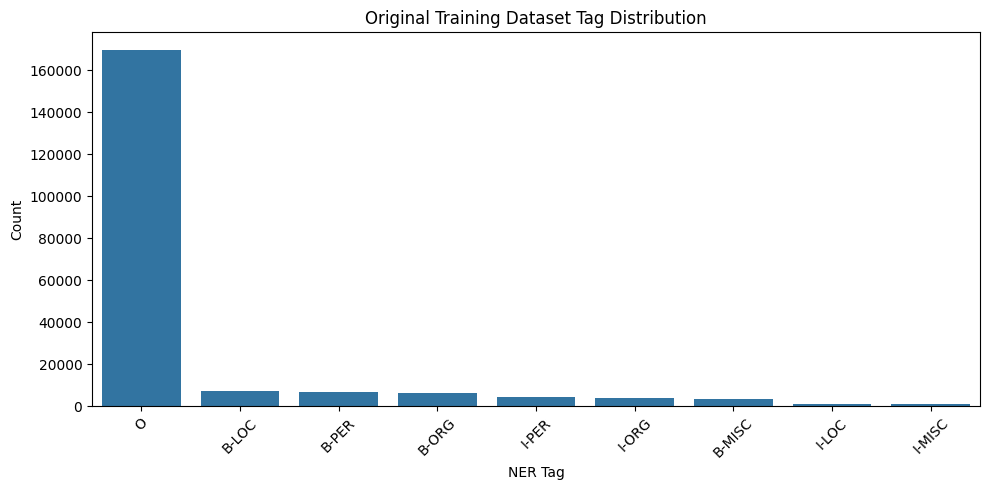

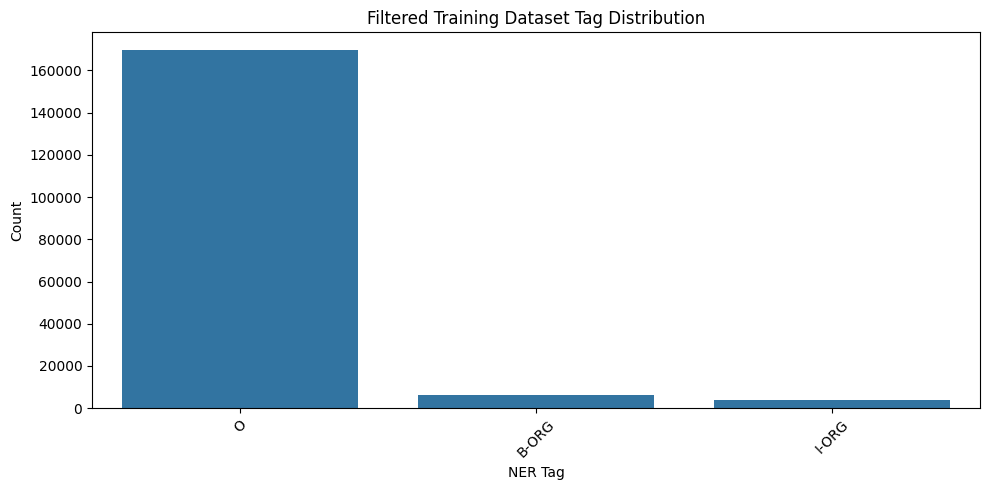

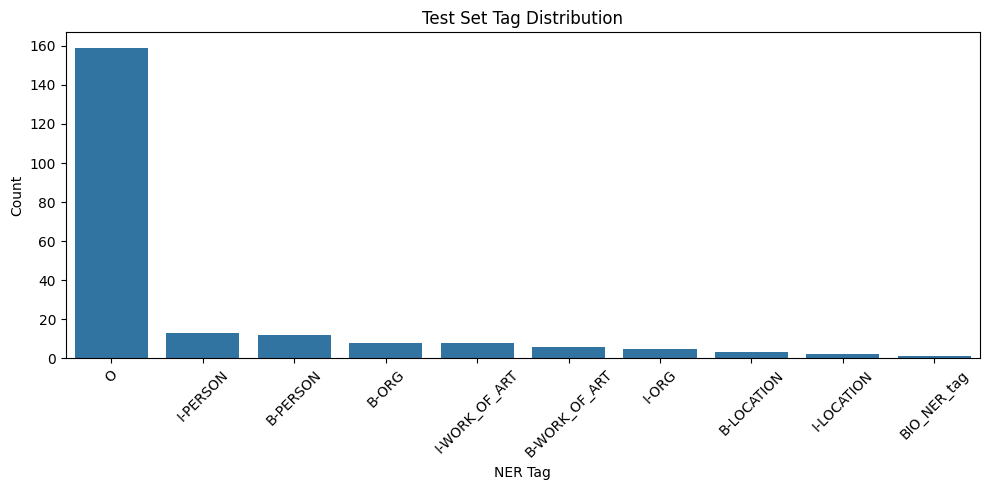

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load data
train_df = pd.read_csv("conll2003_ner_train.csv")  # adjust path as needed
test_df = pd.read_csv("NER-test.tsv", sep="\t", names=["Token", "Label"])

# Define tags of interest
filtered_tags = ['B-PERSON', 'I-PERSON', 'B-ORG', 'I-ORG',
                 'B-LOCATION', 'I-LOCATION', 'B-WORK_OF_ART', 'I-WORK_OF_ART', 'O']

# Plot function
def plot_tag_distribution(df, title, filename):
    tag_counts = df['Label'].dropna().value_counts().sort_values(ascending=False)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=tag_counts.index, y=tag_counts.values)
    plt.title(title)
    plt.ylabel("Count")
    plt.xlabel("NER Tag")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    plt.close()

# Generate and save plots
plot_tag_distribution(train_df, "Original Training Dataset Tag Distribution", "figure1_original_train.png")
plot_tag_distribution(train_df[train_df['Label'].isin(filtered_tags)],
                      "Filtered Training Dataset Tag Distribution", "figure2_filtered_train.png")
plot_tag_distribution(test_df, "Test Set Tag Distribution", "figure3_test_set.png")
